In [1]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Importing Libraries
!pip install transformers
from transformers import AlbertTokenizer, TFAlbertForSequenceClassification, TFTrainer, TFTrainingArguments, DataCollatorWithPadding
import tensorflow as tf
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, matthews_corrcoef
from matplotlib import pyplot as plt


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# GPU Infos

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Dec 14 00:45:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    25W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


## Preprocessing of Dataset 

In [5]:
#from google.colab import drive
#drive.mount('/content/drive')

In [6]:
# Read Data 
df = pd.read_csv('df_all.csv')
df.drop(columns=df.columns[0], axis=1, inplace=True)
df.head()

,text,class
0,rt crooked hillary you didn't lose because yo...,explicit_hate
1,"rt estonian pm : "" i don't want blacks in es...",explicit_hate
2,are a bunch of religious bigots . i hope you e...,explicit_hate
3,hamas is the only one who lies and all those l...,explicit_hate
4,one of the questions never asked : if africans...,explicit_hate


In [7]:
# Check shape of dataframe 
df.shape

(64875, 2)

In [8]:
# drop NA 
df = df.dropna()

In [9]:
# Check distribution of classes
df['class'].value_counts()

not_hate         35977
offensive        19190
implicit_hate     7100
explicit_hate     2519
Name: class, dtype: int64

In [10]:
# Combine classes for binary classification 

# Copy Dataframe first
df_multiclass = df.copy()

# Replace classes 
df_multiclass['class'] = np.where((df_multiclass['class'] == 'not_hate'), 0, df_multiclass['class'])
df_multiclass['class'] = np.where((df_multiclass['class'] == 'offensive'), 1, df_multiclass['class'])
df_multiclass['class'] = np.where((df_multiclass['class'] == 'implicit_hate'), 2, df_multiclass['class'])
df_multiclass['class'] = np.where((df_multiclass['class'] == 'explicit_hate'), 3, df_multiclass['class'])

# show head 
df_multiclass.head()

,text,class
0,rt crooked hillary you didn't lose because yo...,3
1,"rt estonian pm : "" i don't want blacks in es...",3
2,are a bunch of religious bigots . i hope you e...,3
3,hamas is the only one who lies and all those l...,3
4,one of the questions never asked : if africans...,3


In [11]:
# Show Distribution
df_multiclass['class'].value_counts()

0    35977
1    19190
2     7100
3     2519
Name: class, dtype: int64

In [12]:
# Get max number of words 
num_words = df_multiclass['text'].apply(lambda x:len(str(x).split()))
print('The comment with the most words consist of', num_words.max(),'words')

The comment with the most words consist of 268 words


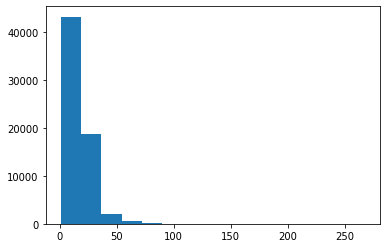

In [13]:
# Visualize 
plt.hist(num_words, bins=15)
plt.show()

No need to change hyperparameters since max word is smaller than default input allows. 

# Train-Test Split

In [14]:
# Create X  
X=list(df_multiclass['text']) 

# Create y 
y=list(df_multiclass['class']) 

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0) 

In [15]:
categories=sorted(list(set(y))) #set will return the unique different entries


In [16]:
num_categories = len(categories)
num_categories

4

# Preprocessing for Model

In [18]:
# Set up an Object for RobertaTokenizerFast

tokenizer = AlbertTokenizer.from_pretrained("albert-base-v2")

# Tokenize X Train & Test Set 
train_input = tokenizer(X_train, truncation=True, padding=True, return_tensors='tf')
test_input = tokenizer(X_test, truncation=True, padding=True, return_tensors='tf')


Downloading:   0%|          | 0.00/760k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/684 [00:00<?, ?B/s]

In [19]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_input),
    y_train
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_input),
    y_test
))

In [20]:
training_args = TFTrainingArguments(
    output_dir='./results',          
    num_train_epochs=3,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=16,   
    warmup_steps = 500,
    weight_decay=0.01,
    logging_steps=10,
    eval_steps = 10
)

In [21]:
with training_args.strategy.scope():
    model = TFAlbertForSequenceClassification.from_pretrained("albert-base-v2", num_labels=num_categories)
trainer = TFTrainer(
    model=model,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=test_dataset,
)

trainer.train()

Downloading:   0%|          | 0.00/63.0M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFAlbertForSequenceClassification.

Some layers of TFAlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.8/dist-packages/transformers/trainer_tf.py:115: FutureWarning: The class `TFTrainer` is deprecated and will be removed in version 5 of Transformers. We recommend using native Keras instead, by calling methods like `fit()` and `predict()` directly on the model object. Detailed examples of the Keras style can be found in our examples at https://github.com/huggingface/transformers/tree/main/examples/tensorflow
  warnings.warn(


In [22]:
output = trainer.predict(test_dataset)[0]
output = np.argmax(output, axis = - 1)

In [23]:
cm=confusion_matrix(y_test,output)
cm

array([[6696,   69,  431,   43],
       [  97, 3685,    0,   71],
       [ 591,    5,  763,   35],
       [  74,  166,  111,  121]])

In [24]:
print(classification_report(y_test, output))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      7239
           1       0.94      0.96      0.95      3853
           2       0.58      0.55      0.57      1394
           3       0.45      0.26      0.33       472

    accuracy                           0.87     12958
   macro avg       0.72      0.67      0.69     12958
weighted avg       0.86      0.87      0.86     12958



In [25]:
trainer.save_model('multiclass_model_albert')

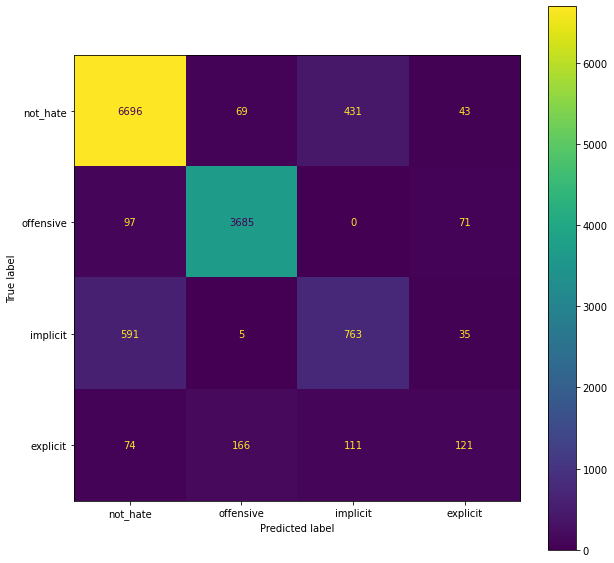

In [26]:
from sklearn import metrics
plt.rcParams['figure.figsize'] = (10, 10)
confusion_matrix = metrics.confusion_matrix(y_test, output)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["not_hate", "offensive", "implicit", "explicit" ])

cm_display.plot()